In [48]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import h5py as h5

import re
import astropy.units as u
from scipy.spatial import cKDTree

time_conv = 977.79222167

In [2]:
sim_list = ['phantom-vacuum-grav', 'phantom-vacuum', 'phantom-Sg10-Rc4.0', 'phantom-vacuum-Sg10-Rc4.0',
            'phantom-vacuum-Sg20-Rc4.0', 'Nbody', 'phantom-vacuum-Sg20-Rc3.5']

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities'],
              basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f


In [41]:
# sn0_list = []
# sn2_list = []
# sn3_list = []
sn4_list = []
sn6_list = []
sn6i_list = []
idx_list = [0, 50, 100, 150, 200]#, 100, 125]
for idx in tqdm(idx_list):
#     sn0 = read_snap(idx, 0, parttype=None, fields=None)
#     sn0_list.append(sn0)
    
#     sn2 = read_snap(idx, 2, parttype=None, fields=None)
#     sn2_list.append(sn2)
    
#     sn3 = read_snap(idx, 3, parttype=None, fields=None)
#     sn3_list.append(sn3)
    
    sn4 = read_snap(idx, 4, parttype=None, fields=None)
    sn4_list.append(sn4)

    sn6 = read_snap(idx, 6, parttype=None, fields=None)
    sn6_list.append(sn6)
    
    try:
        sn6i = read_snap(idx, 6, lvl='lvl3-isotherm', parttype=None, fields=None)
        sn6i_list.append(sn6i)
    except:
        pass



A Jupyter Widget

In [54]:
center = np.array([200, 200, 200])

tz6_list = []
tz6i_list = []
rho6_list = []
rho6i_list = []
tree6_list = []
tree6i_list = []
for i,idx in tqdm(enumerate(idx_list)):
    sn6 = sn6_list[i]
    pos6 = sn6.part0.pos.value - center
    acc6 = sn6.part0.acce
    tz6 = pos6[:,0]*acc6[:,1] - pos6[:,1]*acc6[:,0]
    tz6_list.append(tz6)
    
    tree6 = cKDTree(pos6)
    tree6_list.append(tree6)
    
    rho6 = sn6.part0.rho.value
    rho6_list.append(rho6)
    
    sn6i = sn6i_list[i]
    pos6i = sn6i.part0.pos.value - center
    acc6i = sn6i.part0.acce
    tz6i = pos6i[:,0]*acc6i[:,1] - pos6i[:,1]*acc6i[:,0]
    tz6i_list.append(tz6i)
    
    tree6i = cKDTree(pos6i)
    tree6i_list.append(tree6i)
    
    rho6i = sn6i.part0.rho.value
    rho6i_list.append(rho6i)


A Jupyter Widget

In [44]:
sn6_list[0].part0.acce

array([[-2654.4014  , -5120.7495  ,   540.0476  ],
       [-2654.3901  , -5173.844   ,   562.8328  ],
       [-2674.613   , -5162.641   ,   541.4551  ],
       ...,
       [  -14.707818,   161.7046  ,   -14.748444],
       [  -14.736718,   161.82957 ,    14.669292],
       [   14.694434,   161.84068 ,    14.620894]], dtype=float32)

In [3]:
sn6_fine_list = []
fine_idx_list = [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110]
# fine_idx_list = [98, 99, 100, 101, 102]
for idx in tqdm(fine_idx_list):
    sn6 = read_snap(idx, 6, parttype=[0], fields=['Coordinates', 'Masses', 'StarFormationRate'])
    sn6_fine_list.append(sn6)

A Jupyter Widget

KeyboardInterrupt: 

In [3]:
# sfr0 = read_sfr(0)
# sfr1 = read_sfr(1)
sfr2 = read_sfr(2)
sfr3 = read_sfr(3)
sfr4 = read_sfr(4)
sfr6 = read_sfr(6)

# fourier3 = read_fourier(3)
fourier4 = read_fourier(4)
fourierN = read_fourier(5)
fourier6 = read_fourier(6)
fourier6i = read_fourier(6, lvl='lvl3-isotherm')

In [4]:
def extract_t_A2A0(fourier, idx):

    i = 0

    tlist = np.array(fourier['time'])
    A2A0list = []
    print(fourier['snapshot_000']['Rlist'][idx])
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = fourier[key]['A0'][idx]
        A2r = fourier[key]['A2r'][idx]
        A2i = fourier[key]['A2i'][idx]
    
        A2 = np.sqrt(A2r*A2r + A2i*A2i)
        A2A0list.append(A2/A0)
        i += 1
    
    return np.array(tlist), np.array(A2A0list)

def extract_t_max_A2A0(fourier):

    i = 0

    tlist = np.array(fourier['time'])
    A2A0list = []
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = np.array(fourier[key]['A0'])
        A2r = np.array(fourier[key]['A2r'])
        A2i = np.array(fourier[key]['A2i'])
    
        A2 = np.sqrt(A2r*A2r + A2i*A2i)
#         A2A0 = A2/A0
        A2A0list.append(np.max(A2/A0))
#         A2A0list.append(A2/A0)
        i += 1
    
    return np.array(tlist), np.array(A2A0list)

def extract_t_AmA0(fourier, idx, m):

    i = 0

    tlist = np.array(fourier['time'])
    AmA0list = []
#     print(fourier['snapshot_000']['Rlist'][idx])
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = fourier[key]['A0'][idx]
        Amr = fourier[key]['A'+str(m)+'r'][idx]
        Ami = fourier[key]['A'+str(m)+'i'][idx]
    
        Am = np.sqrt(Amr*Amr + Ami*Ami)
        AmA0list.append(Am/A0)
        i += 1
    
    return np.array(tlist), np.array(AmA0list)

In [5]:
def my_bin(X, Xbins, Y, func=np.mean):
    Xmin = Xbins[0]
    Xmax = Xbins[-1]
    assert Xmin==np.min(Xbins), "First entry of Xbins is not the min value"
    assert Xmax==np.max(Xbins), "Last entry of Xbins is not the max value"

    keys = np.logical_and(X > Xmin, X < Xmax)

    digit = np.digitize(X[keys], Xbins)
    X_avg = [X[keys][digit == i].mean() for i in range(1, len(Xbins))]
    Y_func = [func(Y[keys][digit == i]) for i in range(1, len(Xbins))]

    return np.array(X_avg), np.array(Y_func)

def compute_sfr_profile(sn, center=[200, 200, 200],
                        Rmin=0.1, Rmax=20, nbins=20):

    #get pos of gas
    pos = np.subtract(sn.part0.pos, center)
    R = np.linalg.norm(pos[:,:2], axis=1)
    sfr = np.copy(sn.part0.sfr.value) # Msun/yr

    #do binning
    bins = np.logspace(np.log10(Rmin), np.log10(Rmax), nbins)
#     bins = np.linspace(Rmin, Rmax, nbins)
    R_binned, tot_sfr_binned = my_bin(R, bins, sfr, np.sum)

    # now go through and divide by area of bin
    for i in range(len(R_binned)):
        surf_area = np.pi * (bins[i+1]**2 - bins[i]**2) * (1E6) # 1E6 converts to Msun/yr/pc^2
        tot_sfr_binned[i] /= surf_area
        tot_sfr_binned[i] *= 1E9 # conerts to Msun/pc^2/Gyr

    return R_binned, tot_sfr_binned

def compute_gas_profile(sn, center=[200, 200, 200],
                        Rmin=0.1, Rmax=20, nbins=20):

    #get pos of gas
    pos = np.subtract(sn.part0.pos, center)
    R = np.linalg.norm(pos[:,:2], axis=1)
    gas_mass = 1E10 * np.copy(sn.part0.mass.value)

    #do binning
    bins = np.logspace(np.log10(Rmin), np.log10(Rmax), nbins)
#     bins = np.linspace(Rmin, Rmax, nbins)
    R_binned, tot_sfr_binned = my_bin(R, bins, gas_mass, np.sum)

    # now go through and divide by area of bin
    for i in range(len(R_binned)):
        surf_area = np.pi * (bins[i+1]**2 - bins[i]**2) * (1E6) # 1E6 converts to Msun/pc^2
        tot_sfr_binned[i] /= surf_area
        
    return R_binned, tot_sfr_binned

def compute_HI_profile(sn, center=[200, 200, 200],
                        Rmin=0.1, Rmax=20, nbins=20):

    #get pos of gas
    pos = np.subtract(sn.part0.pos, center)
    R = np.linalg.norm(pos[:,:2], axis=1)
    gas_mass = 1E10 * np.copy(sn.part0.mass.value) * sn.part0.NeutralHydrogenAbundance

    #do binning
    bins = np.logspace(np.log10(Rmin), np.log10(Rmax), nbins)
#     bins = np.linspace(Rmin, Rmax, nbins)
    R_binned, tot_sfr_binned = my_bin(R, bins, gas_mass, np.sum)

    # now go through and divide by area of bin
    for i in range(len(R_binned)):
        surf_area = np.pi * (bins[i+1]**2 - bins[i]**2) * (1E6) # 1E6 converts to Msun/pc^2
        tot_sfr_binned[i] /= surf_area
        
    return R_binned, tot_sfr_binned

def compute_HI_vol_dens(sn, center=[200, 200, 200],
                        Rsun=8.2, dR=0.1, dz=0.2):
    pos = np.subtract(sn.part0.pos, center)
    R = np.linalg.norm(pos[:,:2], axis=1)
    z = pos[:,2]
    gas_mass = 1E10 * np.copy(sn.part0.mass.value) * sn.part0.NeutralHydrogenAbundance
    
    Rbool = np.abs(R-Rsun) < dR
    zbool = np.abs(z) < dz
    
    tot_mass = np.sum(gas_mass[np.logical_and(Rbool, zbool)])
    tot_vol = (np.pi*(Rsun+dR)**2 - np.pi*(Rsun-dR)**2) * (2. * dz) # in kpc^3
    tot_vol *= 1E9 # in pc^3
    
    return tot_mass/tot_vol

def compute_star_vol_dens(sn, center=[200, 200, 200],
                        Rsun=8.2, dR=0.1, dz=0.2):
    
    star_mass = 0
    for i in [2, 3, 4]:
        if sn.NumPart_Total[i] > 0:
            part = getattr(sn, 'part'+str(i))
            pos = np.subtract(part.pos, center)
            R = np.linalg.norm(pos[:,:2], axis=1)
            z = pos[:,2]
            try:
                mass = 1E10 * np.copy(part.mass.value)
            except:
                mass = 1E10 * np.full(sn.NumPart_Total[i], sn.MassTable[i])
    
            Rbool = np.abs(R-Rsun) < dR
            zbool = np.abs(z) < dz
    
            star_mass += np.sum(mass[np.logical_and(Rbool, zbool)])
    
    tot_vol = (np.pi*(Rsun+dR)**2 - np.pi*(Rsun-dR)**2) * (2. * dz) # in kpc^3
    tot_vol *= 1E9 # in pc^3
    
    return star_mass/tot_vol
    

In [6]:
from numba import njit
@njit
def _binned_average(x, y, bins):
    N = len(bins)
    
    sum_x_in_bin = np.zeros(N-1)
    sum_y_in_bin = np.zeros(N-1)
    N_in_bin = np.zeros(N-1)
    
    for i in range(len(x)):
        this_x = x[i]
        for j in range(N-1):
            if this_x > bins[j] and this_x < bins[j+1]:
                sum_x_in_bin[j] += x[i]
                sum_y_in_bin[j] += y[i]
                N_in_bin[j] += 1
    
    for j in range(N-1):
        sum_x_in_bin[j] /= N_in_bin[j]
        sum_y_in_bin[j] /= N_in_bin[j]
    
    return sum_x_in_bin, sum_y_in_bin
    
def binned_average(x, y, dx):
    xmin = np.min(x)
    xmax = np.max(x)

    bins = np.arange(xmin, xmax+dx, dx)
    return _binned_average(x, y, bins)

In [ ]:
sn_list = sn0_list
title = 'exp profile, vacuum'

fig, ax = plt.subplots(1, 1, figsize=(7,7))

ax.axhline(10, c='k', ls='dashed')

for i,idx in enumerate(idx_list):
#     if idx not in [100]:#, 400, 600]:
#         continue
    
    R0, gas0 = compute_HI_profile(sn_list[i])
    time = sn_list[i].Time.value
    l = ax.plot(R0, gas0, label="{:0.0f}".format(time*time_conv))
# #     try:
# #         R1, gas1 = compute_HI_profile(sn1_list[i])
# #         ax.plot(R1, gas1, c=l[0].get_color(), ls='dashed')
# #     except:
# #         pass
    
# #     try:
# #         R2, gas2 = compute_HI_profile(sn2_list[i])
# # #         ax.plot(R2, gas2, c=l[0].get_color(), ls='dotted')
# #     except:
# #         pass

# R, gas = compute_HI_profile(sn)
# ax.plot(R, gas)

ax.set(yscale='log', ylim=(0.1, 100), xlabel='R [kpc]', ylabel='surf dens [Msun/pc^2]', title=title)
ax.legend()
plt.show()

AxesSubplot(0.125,0.125;0.352273x0.755)
AxesSubplot(0.547727,0.125;0.352273x0.755)


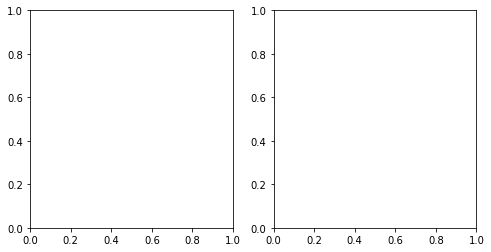

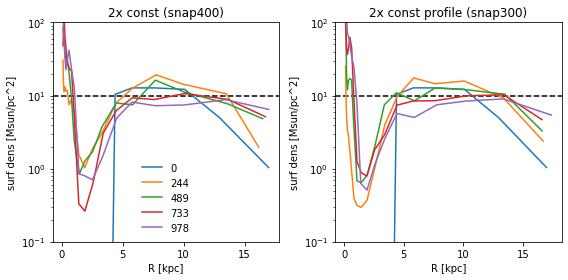

In [10]:
# fig, ax = plt.subplots(2, 2, figsize=(8,8))
fig, ax = plt.subplots(1, 2, figsize=(8,4))

# sn_list_list = [sn0_list, sn2_list, sn3_list, sn4_list]
# title_list = ['exp profile, vacuum', 'const profile, no vacuum', 'const profile, vacuum', '2x const profile, vacuum']

sn_list_list = [sn4_list, sn6_list]
title_list = ['2x const (snap400)', '2x const profile (snap300)']

for sn_list, title, this_ax in zip(sn_list_list, title_list, ax):
    print(this_ax)
    this_ax.set(yscale='log', ylim=(0.1, 100), xlabel='R [kpc]', ylabel='surf dens [Msun/pc^2]', title=title)
    this_ax.axhline(10, c='k', ls='dashed')
    
    for i, idx in enumerate(idx_list):
#         try:
            R, gas = compute_HI_profile(sn_list[i])
#             print(np.median(gas))
            time = sn_list[i].Time.value
            l = this_ax.plot(R, gas, label="{:0.0f}".format(time*time_conv))
#         except:
#             pass
ax[0].legend(frameon=False)

fig.tight_layout()
plt.show()
    

AxesSubplot(0.125,0.125;0.352273x0.755)
AxesSubplot(0.547727,0.125;0.352273x0.755)


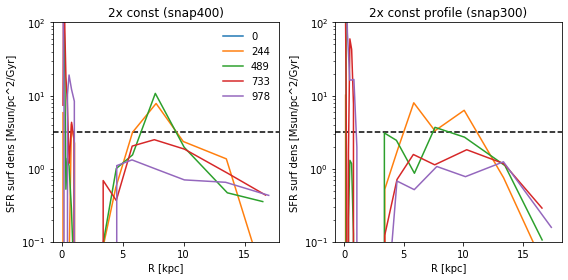

In [11]:
# fig, ax = plt.subplots(2, 2, figsize=(8,8))
fig, ax = plt.subplots(1, 2, figsize=(8,4))

# sn_list_list = [sn0_list, sn2_list, sn3_list, sn4_list]
# title_list = ['exp profile, vacuum', 'const profile, no vacuum', 'const profile, vacuum', '2x const profile, vacuum']

sn_list_list = [sn4_list, sn6_list]
title_list = ['2x const (snap400)', '2x const profile (snap300)']

for sn_list, title, this_ax in zip(sn_list_list, title_list, ax):
    print(this_ax)
    this_ax.set(yscale='log', ylim=(0.1, 100), xlabel='R [kpc]', ylabel='SFR surf dens [Msun/pc^2/Gyr]', title=title)
    this_ax.axhline(10.**(0.5), c='k', ls='dashed')
    
    for i, idx in enumerate(idx_list):
#         try:
            R, gas = compute_sfr_profile(sn_list[i])
#             print(np.median(gas))
            time = sn_list[i].Time.value
            l = this_ax.plot(R, gas, label="{:0.0f}".format(time*time_conv))
#         except:
#             pass
ax[0].legend(frameon=False)

fig.tight_layout()
plt.show()
    

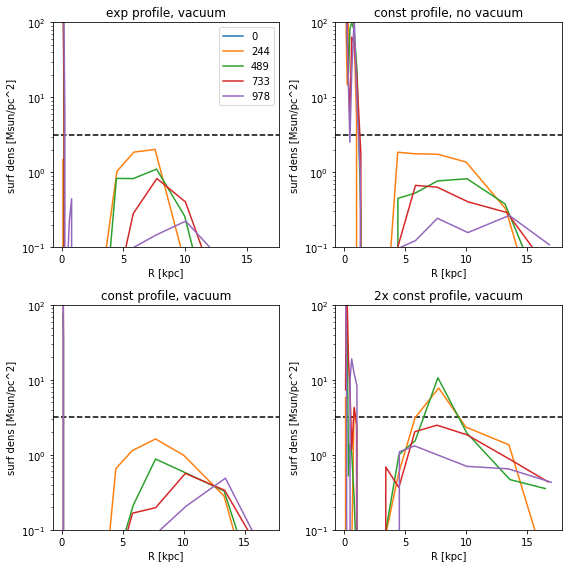

In [62]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))

sn_list_list = [sn0_list, sn2_list, sn3_list, sn4_list]
title_list = ['exp profile, vacuum', 'const profile, no vacuum', 'const profile, vacuum', '2x const profile, vacuum']

for sn_list, title, this_ax in zip(sn_list_list, title_list, ax.flatten()):
    this_ax.set(yscale='log', ylim=(0.1, 100), xlabel='R [kpc]', ylabel='surf dens [Msun/pc^2]', title=title)
    this_ax.axhline(10.**(0.5), c='k', ls='dashed')
    
    for i, idx in enumerate(idx_list):
        try:
            R, gas = compute_sfr_profile(sn_list[i])
            time = sn_list[i].Time.value
            l = this_ax.plot(R, gas, label="{:0.0f}".format(time*time_conv))
        except:
            pass

ax[0][0].legend()
        
fig.tight_layout()
plt.show()
    

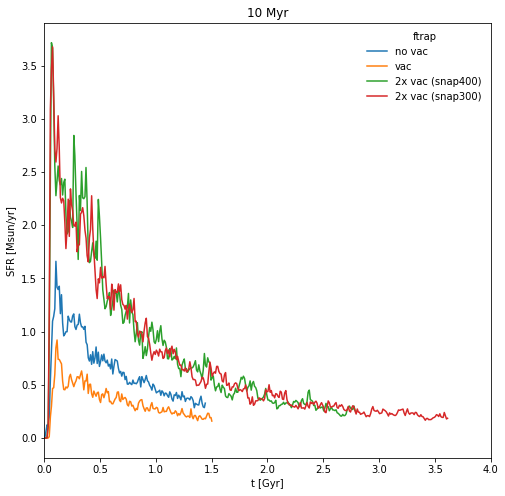

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dt = 0.01

t, SFR = binned_average(sfr2[:,0], sfr2[:,2], dt)
ax.plot(t, SFR, label='no vac')

t, SFR = binned_average(sfr3[:,0], sfr3[:,2], dt)
ax.plot(t, SFR, label='vac')

t, SFR = binned_average(sfr4[:,0], sfr4[:,2], dt)
ax.plot(t, SFR, label='2x vac (snap400)')

t, SFR = binned_average(sfr6[:,0], sfr6[:,2], dt)
ax.plot(t, SFR, label='2x vac (snap300)')

# t, SFR = binned_average(sfr_8[:,0], sfr_8[:,2], dt)
# ax.plot(t, SFR, label='8')

ax.legend(frameon=False, title='ftrap')
ax.set(xlabel='t [Gyr]', ylabel='SFR [Msun/yr]')
ax.set_xlim(0, 4)
ax.set_title('10 Myr')
plt.show()

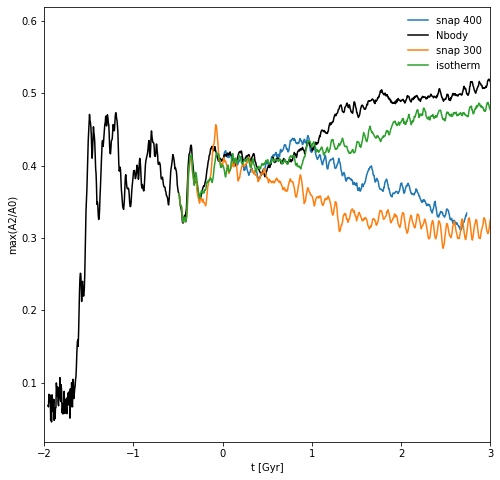

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dt = 0.01

# t, A2A0 = extract_t_max_A2A0(fourier3)
# ax.plot(t/1000.0, A2A0, label='Sg 10')

t, A2A0 = extract_t_max_A2A0(fourier4)
ax.plot(t/1000.0, A2A0, label='snap 400')

start_snap = 400
t, A2A0 = extract_t_max_A2A0(fourierN)
t -= t[400]
t300 = t[300]
ax.plot(t/1000.0, A2A0, label='Nbody', c='k')

t, A2A0 = extract_t_max_A2A0(fourier6)
t += t300
ax.plot(t/1000.0, A2A0, label='snap 300')

t, A2A0 = extract_t_max_A2A0(fourier6i)
t += t300
ax.plot(t/1000.0, A2A0, label='isotherm')

# t, SFR = binned_average(sfr_8[:,0], sfr_8[:,2], dt)
# ax.plot(t, SFR, label='8')

ax.legend(frameon=False)
ax.set(xlabel='t [Gyr]', ylabel='max(A2/A0)', xlim=(0, 1))
ax.set_xlim(-2, 3)
plt.show()

In [22]:
t

array([   0.        ,    5.25181781,   10.02619763,   14.80057746,
         19.57495728,   24.82677509,   29.60115491,   34.37553474,
         39.14991456,   44.40173237,   49.17611219,   53.95049202,
         58.72487184,   63.97668965,   68.75106947,   73.5254493 ,
         78.29982912,   83.55164693,   88.32602675,   93.10040658,
         97.8747864 ,  103.12660421,  107.90098403,  112.67536386,
        117.44974368,  122.22412351,  127.47594131,  132.25032114,
        137.02470096,  141.79908079,  147.05089859,  151.82527842,
        156.59965824,  161.37403807,  166.62585588,  171.4002357 ,
        176.17461552,  180.94899535,  186.20081316,  190.97519298,
        195.7495728 ,  200.52395263,  205.77577044,  210.55015026,
        215.32453009,  220.09890991,  225.35072772,  230.12510754,
        234.89948737,  239.67386719,  244.44824701,  249.70006482,
        254.47444465,  259.24882447,  264.0232043 ,  269.2750221 ,
        274.04940193,  278.82378175,  283.59816158,  288.84997

## Pattern Speed

In [30]:
def get_bar_angle(phi, firstkey):
    out = np.zeros(len(phi))

    # set the first bar angle
    first_bar_angle = phi[firstkey]/2.0
    out[firstkey] = first_bar_angle
    
    # set all subsequent angles
    for i in np.arange(firstkey+1, len(out)):
        dphi = phi[i] - phi[i-1]
        if dphi < 0:
            dphi += 2.*np.pi
        out[i] = out[i-1] + dphi/2.0

    # set all previous angles to be the bar angle
    for i in np.arange(0, firstkey):
        out[i] = first_bar_angle

    return out

def get_sorted_keys(dat):
    keys = list(dat.keys())
    # only keep keys that are snapshot keys
    keys = [k for k in keys if 'snapshot' in k]

    # extract and sort indices
    indices = [int(re.findall(r'\d?\d?\d\d\d', k)[0]) for k in keys]
    sorted_arg = np.argsort(indices)
    keys_sorted = [keys[i] for i in sorted_arg]

    return keys_sorted

def get_A2_angle(dat, keys, Rbin):
    Rlist = np.array([np.array(dat[k]['Rlist']) for k in keys])
    A2r = np.array([np.array(dat[k]['A2r']) for k in keys])
    A2i = np.array([np.array(dat[k]['A2i']) for k in keys])
    phi = np.arctan2(A2i, A2r)
    phi = phi[:,Rbin]
    R_at_Rbin = Rlist[:,Rbin]
    
    time = np.array(dat['time'])

    return time, R_at_Rbin, phi

def get_bar_length(dat, keys, Rmin=2, Rmax=10, ratio_cut = 2):
    Rlist = np.array([np.array(dat[k]['Rlist']) for k in keys])

    A0 = np.array([np.array(dat[k]['A0']) for k in keys])
    A1r = np.array([np.array(dat[k]['A1r']) for k in keys])
    A1i = np.array([np.array(dat[k]['A1i']) for k in keys])
    A2r = np.array([np.array(dat[k]['A2r']) for k in keys])
    A2i = np.array([np.array(dat[k]['A2i']) for k in keys])
    A3r = np.array([np.array(dat[k]['A3r']) for k in keys])
    A3i = np.array([np.array(dat[k]['A3i']) for k in keys])
    A4r = np.array([np.array(dat[k]['A4r']) for k in keys])
    A4i = np.array([np.array(dat[k]['A4i']) for k in keys])
    A5r = np.array([np.array(dat[k]['A5r']) for k in keys])
    A5i = np.array([np.array(dat[k]['A5i']) for k in keys])
    A6r = np.array([np.array(dat[k]['A6r']) for k in keys])
    A6i = np.array([np.array(dat[k]['A6i']) for k in keys])
    
    I0 = A0/2.
    I1 = np.sqrt(A1r*A1r + A1i*A1i)
    I2 = np.sqrt(A2r*A2r + A2i*A2i)
    I3 = np.sqrt(A3r*A3r + A3i*A3i)
    I4 = np.sqrt(A4r*A4r + A4i*A4i)
    I5 = np.sqrt(A5r*A5r + A5i*A5i)
    I6 = np.sqrt(A6r*A6r + A6i*A6i)
    
    Ib = I0 + I2 + I4 + I6
    Iib = I0 - I2 + I4 - I6
    
    IbIib = Ib/Iib
    
    Rbar_list = []
    for i,k in enumerate(keys):
        R = Rlist[i,:]
        ratio = IbIib[i,:]
        
        Rkey = np.logical_and(R > Rmin, R< Rmax)
        ratio = ratio[Rkey]
        R = R[Rkey]
        j = 0
        try:
            while ratio[j] > ratio_cut:
                j += 1
            Rbar = R[j-1] + (ratio_cut - ratio[j-1]) * (R[j]-R[j-1])/(ratio[j]-ratio[j-1])
        except:
            Rbar = np.nan
        Rbar_list.append(Rbar)

    time = np.array(dat['time'])    
    
    return time, np.array(Rbar_list)

def evaluate_polynomial(pfit, n, time, bar_angle_firstkey, firstkey):
    pfit_n = pfit[n]
    poly_bar_angle = np.zeros(len(time))
    poly_pattern_speed = np.zeros(len(time))

    for i in range(n+1):
        ba = pfit_n[i] * time ** (n-i)
        poly_bar_angle[firstkey:] += ba[firstkey:]
        ps = (n-i) * pfit_n[i] * time**(n-1-i)
        poly_pattern_speed[firstkey:] += ps[firstkey:]

    poly_bar_angle[:firstkey] += bar_angle_firstkey

    poly_pattern_speed = poly_pattern_speed / u.Myr
    poly_pattern_speed = poly_pattern_speed.to_value(u.km/u.s/u.kpc)

    return poly_bar_angle, poly_pattern_speed

def master_bar_angle(dat, Rbin = 5, firstkey = 150, nmax = 10):
    # try loading snapshot
#     dat = h5.File(fname, mode='r')
    out = {}

    keys = get_sorted_keys(dat)
    time, R, phi = get_A2_angle(dat, keys, Rbin)
    time, Rbar = get_bar_length(dat, keys)
#     Rlist, Iibar = get_bar_length(dat, keys)
    bar_angle = get_bar_angle(phi, firstkey)

    pattern_speed = np.gradient(bar_angle, time) / u.Myr
    pattern_speed = pattern_speed.to_value(u.km/u.s/u.kpc)

    pfit = [np.polyfit(time[firstkey:], bar_angle[firstkey:], i) for i in range(nmax)]
    
    out['time'] = time
    out['firstkey'] = firstkey
    out['R'] = R
    out['Rbar'] = Rbar
    out['phi'] = phi
    out['bar_angle'] = bar_angle
    out['pattern_speed'] = pattern_speed
    out['pfit'] = pfit

    # now evaluate the polynomial for each fit and save the result
    out['poly_eval'] = {}
    for n in range(nmax):
        poly_bar_angle, poly_pattern_speed = evaluate_polynomial(pfit, n, time, bar_angle[firstkey], firstkey)

        out['poly_eval'][n] = (poly_bar_angle, poly_pattern_speed)

    return out
#     return Rlist, Iibar

In [37]:
outN = master_bar_angle(fourierN)
# out3 = master_bar_angle(fourier3, firstkey=0)
out4 = master_bar_angle(fourier4, firstkey=0)
out6 = master_bar_angle(fourier6, firstkey=0)
out6i = master_bar_angle(fourier6i, firstkey=0)

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in reciprocal
/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in multiply


In [31]:
outN = master_bar_angle(fourierN)

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in reciprocal
/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in multiply


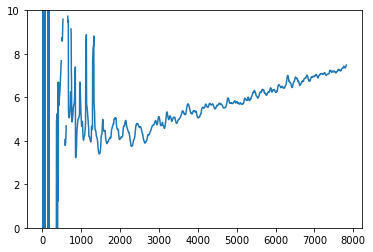

In [36]:
plt.plot(outN['time'], outN['Rbar'])

plt.ylim(0, 10)
plt.show()



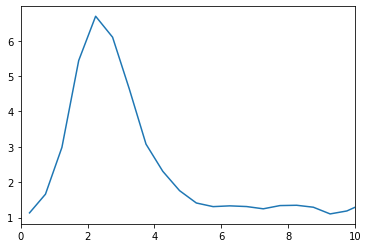

In [27]:
plt.plot(Rlist[400,:], Iibar[400,:])
plt.xlim(0, 10)
plt.show()

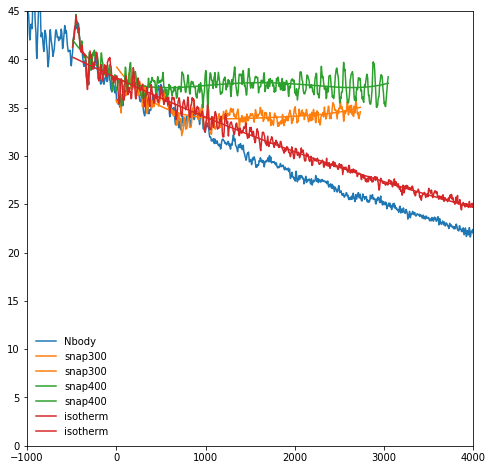

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
n=5

dat = outN
name = 'Nbody'

time = dat['time']
ba, ps = dat['poly_eval'][n]
true_ps = dat['pattern_speed']
# ax.plot(time-time[400], ps, label=name, c='k')
ax.plot(time-time[400], true_ps, label=name)
dt = time[300] - time[400]

# dat = out3
# name = 'Sg 10'

# time = dat['time']
# ba, ps = dat['poly_eval'][n]
# true_ps = dat['pattern_speed']
# # ax.plot(time-time[0], ps, label=name)
# ax.plot(time-time[0], true_ps, label=name)

dat = out4
name = 'snap300'

time = dat['time']
ba, ps = dat['poly_eval'][n]
true_ps = dat['pattern_speed']
l=ax.plot(time-time[0], ps, label=name)
ax.plot(time-time[0], true_ps, label=name, c=l[0].get_color())

dat = out6
name = 'snap400'

time = dat['time'] + dt
ba, ps = dat['poly_eval'][n]
true_ps = dat['pattern_speed']
l=ax.plot(time, ps, label=name)
ax.plot(time, true_ps, label=name, c=l[0].get_color())


dat = out6i
name = 'isotherm'

time = dat['time'] + dt
ba, ps = dat['poly_eval'][n]
true_ps = dat['pattern_speed']
l=ax.plot(time, ps, label=name)
ax.plot(time, true_ps, label=name, c=l[0].get_color())


ax.legend(frameon=False)

ax.set(xlim=(-1000, 4000))
ax.set(ylim=(0, 45))
plt.show()

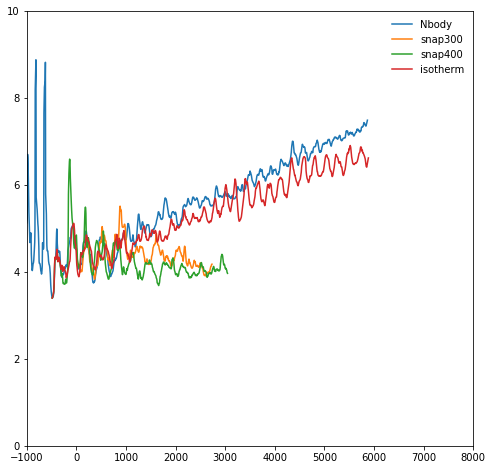

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
n=5

dat = outN
name = 'Nbody'

time = dat['time']
Rbar = dat['Rbar']
# ax.plot(time-time[400], ps, label=name, c='k')
ax.plot(time-time[400], Rbar, label=name)
dt = time[300] - time[400]

# dat = out3
# name = 'Sg 10'

# time = dat['time']
# ba, ps = dat['poly_eval'][n]
# true_ps = dat['pattern_speed']
# # ax.plot(time-time[0], ps, label=name)
# ax.plot(time-time[0], true_ps, label=name)

dat = out4
name = 'snap300'

time = dat['time']
Rbar = dat['Rbar']
# l=ax.plot(time-time[0], ps, label=name)
ax.plot(time-time[0], Rbar, label=name)#, c=l[0].get_color())

dat = out6
name = 'snap400'

time = dat['time'] + dt
Rbar = dat['Rbar']
# l=ax.plot(time, ps, label=name)
ax.plot(time, Rbar, label=name)#, c=l[0].get_color())


dat = out6i
name = 'isotherm'

time = dat['time'] + dt
Rbar = dat['Rbar']
# l=ax.plot(time, ps, label=name)
ax.plot(time, Rbar, label=name)#, c=l[0].get_color())


ax.legend(frameon=False)

ax.set(xlim=(-1000, 8000))
ax.set(ylim=(0, 10))
plt.show()

In [62]:
def compute_SFR_azimuth(sn, out, sn_idx, R=6, dR=1, center=np.array([200, 200, 200])):
    
    

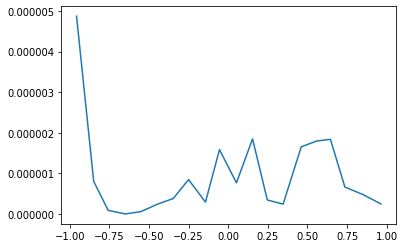

In [18]:
# compute_SFR_azimuth(sn6_list[2], out6, 100)
for i,idx in enumerate(fine_idx_list):
    sn = sn6_fine_list[i]
    out = out6
    sn_idx = idx
    R0 = 6
    dR = 1
    center = np.array([200, 200, 200])

    pos = sn.part0.pos.value - center
    SFR = sn.part0.sfr.value
    R = np.linalg.norm(pos[:,:2], axis=1)

    phi = np.arctan2(pos[:,1], pos[:,0])
    
    ba = out['bar_angle'][sn_idx]
    phi = np.mod(phi - ba, 2.*np.pi) - np.pi

    key = np.logical_and(R > R0 - dR/2.0, R < R0 + dR/2.0)

    phi_bin, SFR_bin = binned_average(phi[key]/np.pi, SFR[key], 0.1)
    if i==0:
        ave_phi_bin = np.copy(phi_bin)
        ave_SFR_bin = np.copy(SFR_bin)
        N = 1
    else:
        ave_phi_bin += phi_bin
        ave_SFR_bin += SFR_bin
        N += 1

ave_phi_bin /= N
ave_SFR_bin /= N

plt.plot(ave_phi_bin, ave_SFR_bin)
plt.show()


###### sn = sn6_fine_list

In [50]:

from numba import njit

@njit
def create_plot_pos(x, y, nres):
    plot_pos = np.zeros((nres*nres, 3))
    for i in range(len(x)):
        for j in range(len(y)):
            plot_pos[i*nres + j][0]=x[i][0]
            plot_pos[i*nres + j][1]=y[0][j]

    return plot_pos

x, y = np.meshgrid(np.linspace(-15, 15, nres), np.linspace(-15, 15, nres), indexing='ij')
plot_pos = create_plot_pos(x, y, nres)
# print(plot_pos)

In [55]:
nres = 256
x, y = np.meshgrid(np.linspace(-15, 15, nres), np.linspace(-15, 15, nres), indexing='ij')
plot_pos = create_plot_pos(x, y, nres)

i = 2
tree = tree6_list[i]
dens = rho6_list[i]
tz = tz6_list[i]

_, key = tree.query(plot_pos)
plot_dens = dens[key]
plot_dens_map = np.reshape(plot_dens, (nres, nres))
plot_tz = tz[key]
plot_tz_map = np.reshape(plot_tz, (nres, nres))

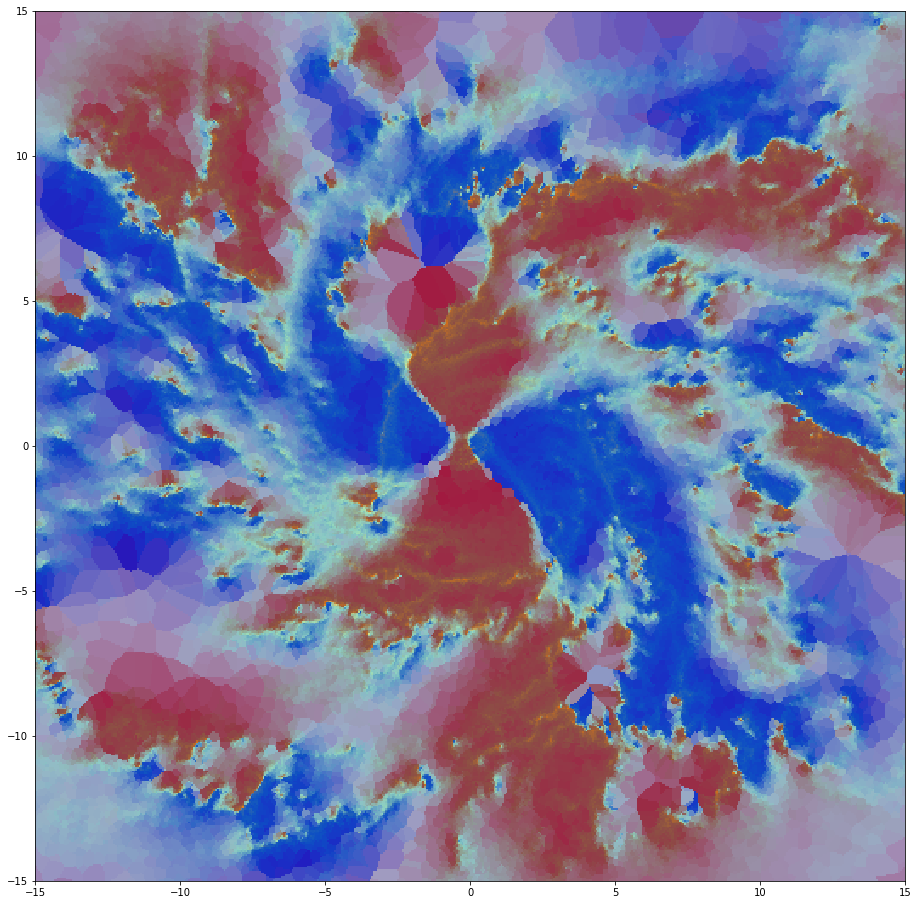

In [84]:
nres = 512
x, y = np.meshgrid(np.linspace(-15, 15, nres), np.linspace(-15, 15, nres), indexing='ij')
plot_pos = create_plot_pos(x, y, nres)

i = 2
tree = tree6_list[i]
dens = rho6_list[i]
tz = tz6_list[i]

_, key = tree.query(plot_pos)
plot_dens = dens[key]
plot_dens_map = np.reshape(plot_dens, (nres, nres))
plot_tz = tz[key]
plot_tz_map = np.reshape(plot_tz, (nres, nres))

# # # # #

fig, ax = plt.subplots(1, 1, figsize=(16, 16))
extent = [-15, 15, -15, 15]
ax.imshow(plot_dens_map.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(), cmap='viridis')# cmap=cmocean.cm.ice)
ax.imshow(plot_tz_map.T, extent=extent, origin='lower', vmin=-3000, vmax=3000, cmap='bwr', alpha=0.5)
plt.show()

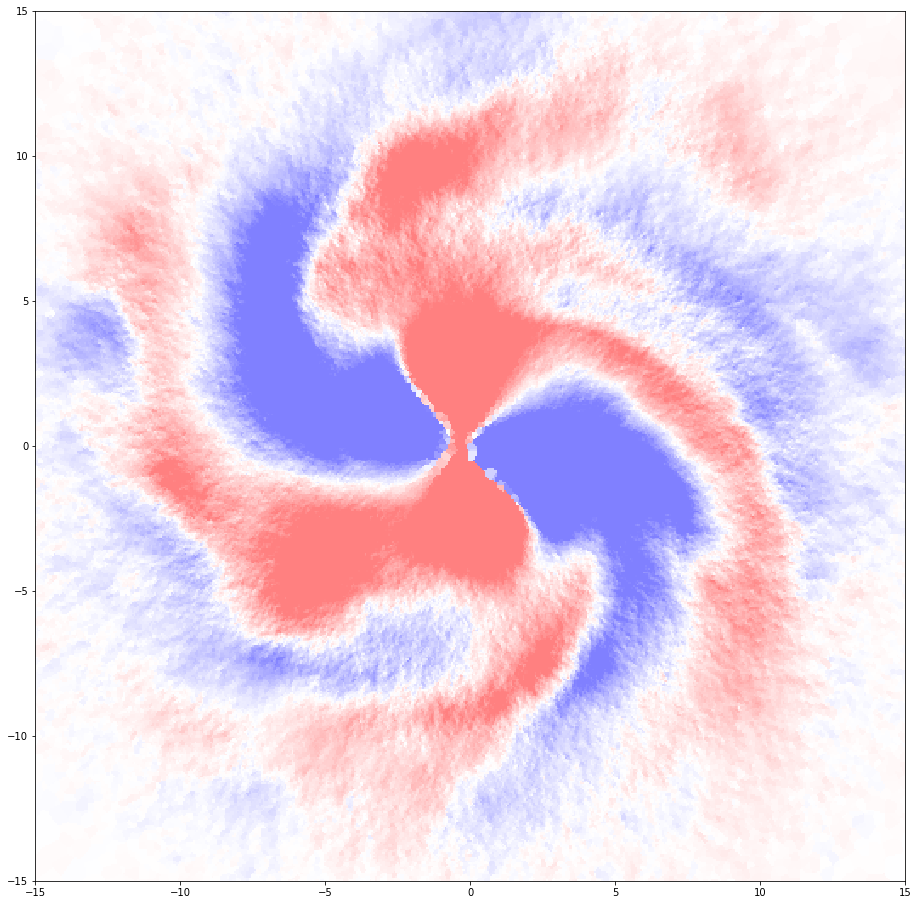

In [86]:
nres = 512
x, y = np.meshgrid(np.linspace(-15, 15, nres), np.linspace(-15, 15, nres), indexing='ij')
plot_posi = create_plot_pos(x, y, nres)

i = 2
treei = tree6i_list[i]
densi = rho6i_list[i]
tzi = tz6i_list[i]

_, keyi = treei.query(plot_posi)
plot_densi = densi[keyi]
plot_dens_mapi = np.reshape(plot_densi, (nres, nres))
plot_tzi = tzi[keyi]
plot_tz_mapi = np.reshape(plot_tzi, (nres, nres))

# # # # #

fig, ax = plt.subplots(1, 1, figsize=(16, 16))
extent = [-15, 15, -15, 15]
# ax.imshow(plot_dens_mapi.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(), cmap='viridis')# cmap=cmocean.cm.ice)
ax.imshow(plot_tz_mapi.T, extent=extent, origin='lower', vmin=-3000, vmax=3000, cmap='bwr', alpha=0.5)
plt.show()

In [62]:
np.median(np.abs(plot_tz_map))

1642.5763425154373